In [136]:
import osmnx as ox
import networkx as nx
import pickle
import math
import numpy as np
import geopandas as gpd
import pandas as pd
import geopy.distance

In [2]:
class DirectionInstruction:
    def __init__(self, text):
        self.text=text
        self.data={}
    def extend(self,label='null', value='null'):
        self.data[label] = value

In [3]:

class RouteDescription:
    def __init__(self, destination):
        #self.origin = origin
        self.destination = destination
        self.steps = []

    def addStep(self, directionInstruction):
        self.steps.append(directionInstruction)

In [4]:
graphMiddle = "Van Lennepbuurt, Amsterdam, North Holland, Netherlands"
place_name = "Albert Heijn, 186, Amstelveenseweg, Schinkelbuurt, Amsterdam, North Holland, Netherlands, 1075XR, Netherlands"

In [5]:
Middle = graphMiddle
distance=8500

In [6]:
traffic_signals = ox.geometries.geometries_from_address(Middle,dist=distance, tags = {"highway":"traffic_signals"},  )

In [7]:
#crossings=ox.geometries.geometries_from_address(Middle, dist=distance, tags = {"crossing":"marked"} )

In [8]:
#roundabouts=ox.geometries.geometries_from_address(Middle,dist=distance, tags = {"junction":"roundabout"} )

In [9]:
#highways = ox.geometries.geometries_from_address(Middle,dist=650, tags = {"highway":["motorway","trunk", "primary", "secondary","tertiary","unclassified", "residential","road"]} )

In [10]:
#graph = ox.graph_from_address(Middle,dist=distance, network_type='drive',simplify = True)
#ox.distance.nearest_nodes(graph, 8.435432953597548, 47.39719131318801)
#ox.plot.plot_graph_routes(graph,["N", "N2814628451"] )

In [121]:
#CHANGE BACK TO MIDDLE
ox.settings.all_oneway = False
ox.settings.useful_tags_node = ["ref", "highway", "traffic_signals"] # Default is ["ref", "highway"]
ox.settings.useful_tags_way = ["bridge", "tunnel", "oneway", "lanes", "ref", "name", "highway", "maxspeed", "service","junction", "turn","destination", "destination:ref"] # Default is ["bridge", "tunnel", "oneway", "lanes", "ref", "name", "highway", "service", "access", "area", "landuse", "width", "est_width", "junction"]
custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|road"]'
G = ox.graph.graph_from_address(Middle,dist=distance, network_type='drive',simplify=False, custom_filter=custom_filter)

In [12]:
def linestring_to_points(feature,line):
    return {feature:line.coords}

In [13]:
def calculate_direction(line):
    A=line[0]
    B=line[1]
    begin=math.atan2( B[1] - A[1], B[0] - A[0] ) * ( 180 / math.pi )

    C=line[-2]
    D=line[-1]
    end=math.atan2( D[1] - C[1], D[0] - C[0] ) * ( 180 / math.pi )

    return {'begin':begin, 'end':end}

In [14]:
def stringify(string):
    if isinstance(string, list):
        return ', '.join(map( lambda x: x.lower(), string))
    return f'{string}'.lower()

In [15]:
# create nodes, edges GeoDataFrames and fill in all edge geometry attributes
# then re-create a MultiDiGraph from those GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)
#extract the points from the LineStrings, the apply function doesn't require a dict as they remain indexed in the output DataFrame.
edges['points'] = edges.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
# calculate the direction of the way at the beginning and ending (to decide ways connected but in opposite directions)
edges['directions'] = edges.apply(lambda x: calculate_direction(x['points']), axis=1)
# reanme name attribute (it is already used by the edge u, v, r struct)
edges['streetName'] = edges.apply(lambda x: stringify(x['name']), axis=1)
edges['destination'] = edges.apply(lambda x: stringify(x['destination']), axis=1)
edges['destination:ref'] = edges.apply(lambda x: stringify(x['destination:ref']), axis=1)
edges.rename(columns={'name':'Name'})
edges['U'] = edges.apply(lambda x: x.name[0], axis=1)
edges['V'] = edges.apply(lambda x: x.name[1], axis=1)
edges['REF'] = edges.apply(lambda x: stringify(x['ref']),axis=1)
G2 = ox.utils_graph.graph_from_gdfs(nodes, edges, graph_attrs=G.graph, )
for u, v, data in G2.edges(keys=False, data=True):
    assert 'geometry' in data

#remove the attribute containing Linestring.
att_list = ['geometry']
for n1, n2, d in G2.edges(data=True):
    for att in att_list:
        d.pop(att, None)

In [16]:
#projected=ox.project_graph(simple_G, to_crs='EPSG:3035')
projected=ox.project_graph(G, to_crs='EPSG:3035')
#have to work on tolerance pl:(https://nominatim.openstreetmap.org/ui/details.html?osmtype=W&osmid=89524318)
G_with_intersection = ox.simplification.consolidate_intersections(projected, tolerance=5, rebuild_graph=True, dead_ends=True, reconnect_edges=True)

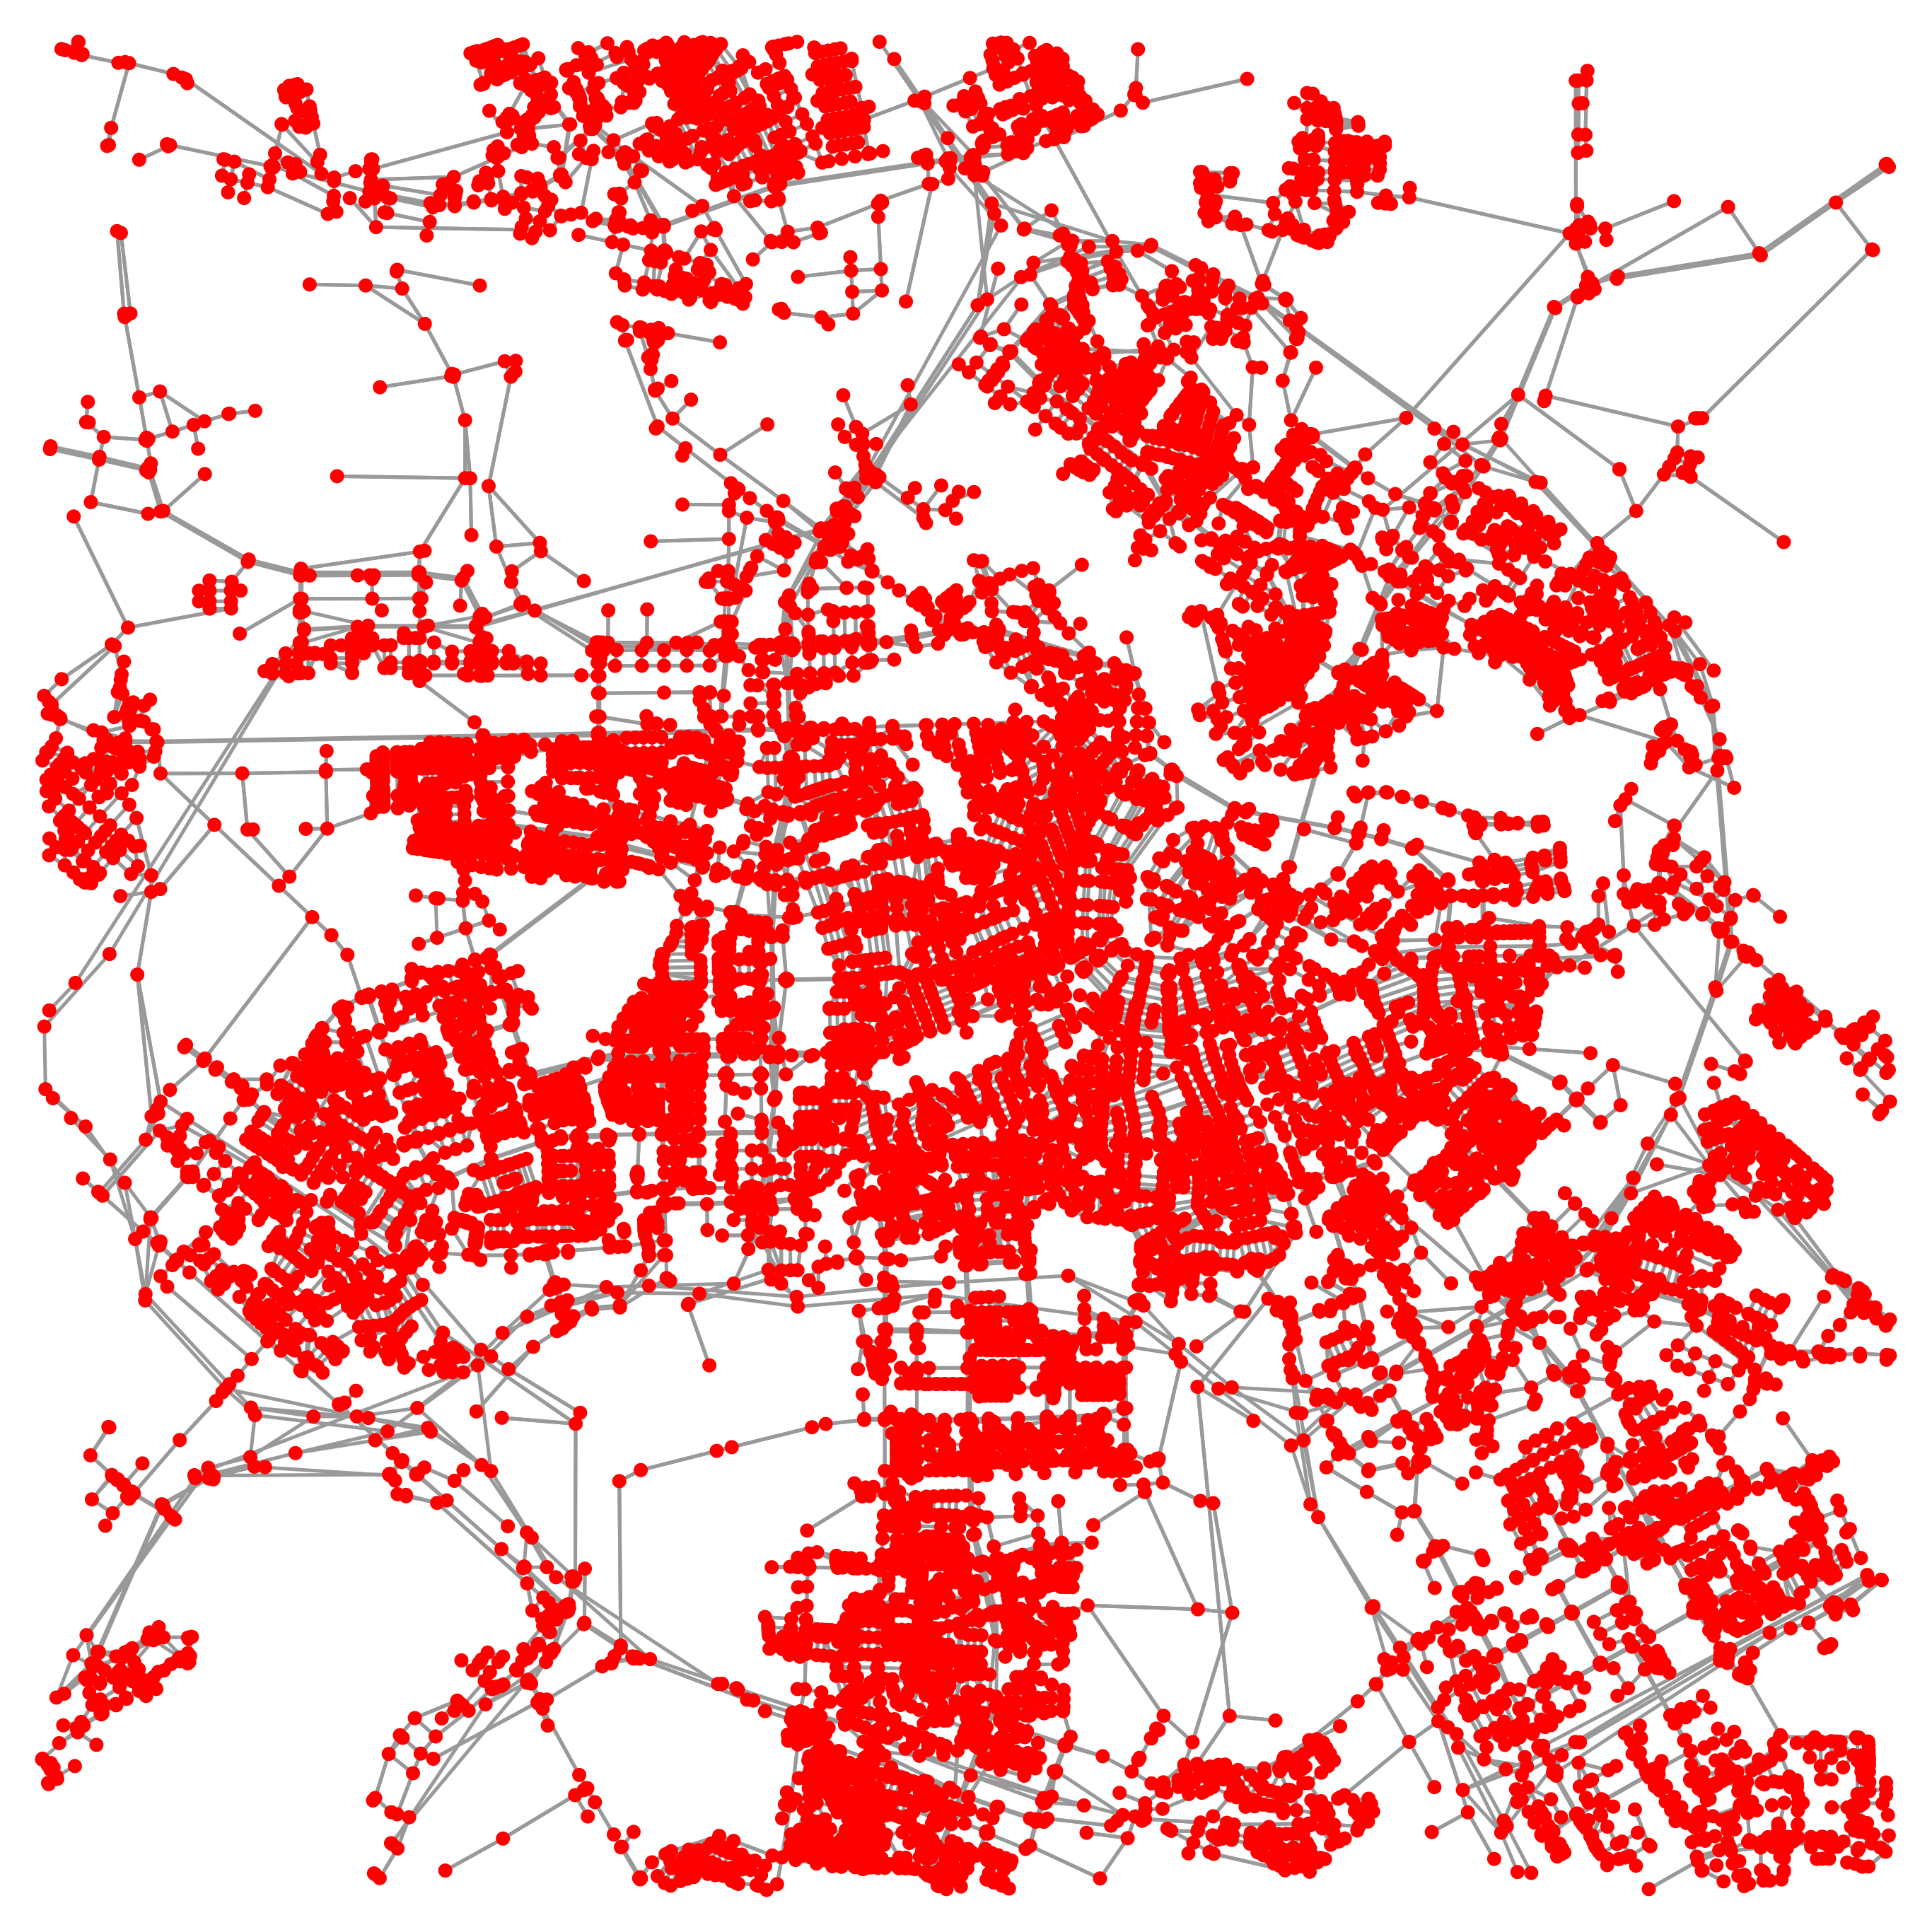

(<Figure size 3600x3600 with 1 Axes>, <AxesSubplot:>)

In [17]:
#print(ox.projection.is_projected('EPSG:3035'))
#ox.plot_graph_folium(simple_G, node_color='g',figsize=(30,30))
ox.plot_graph(G2, node_color='r',figsize=(50,50),node_size=400,bgcolor='white',edge_linewidth=5)
#ox.plot_graph(G_with_intersection, node_color='g',figsize=(50,50))
#ox.plot_graph_folium(G2,popup_attribute="osmid")

In [18]:
graph_G = ox.graph_to_gdfs(G2)

In [19]:
#nodes, edges = ox.graph_to_gdfs(G_with_intersection)

In [20]:
#nx.get_edge_attributes(G_with_intersection,name='osmid')

In [21]:
class Point:
    def __init__(self, x,y):
        self.x=x
        self.y=y

In [22]:
def is_right(a, b, c):
    return (b.x - a.x)*(c.y - a.y) > (b.y - a.y)*(c.x - a.x)
    #Cross Product
    #Where a = line point 1; b = line point 2; c = point to check against.
    #If the formula is equal to 0, the points are colinear.
    #If the line is horizontal, then this returns true if the point is above the line.

In [23]:
def list_duplicates(l):
    seen = set(l)
    return list(seen)

In [24]:
def get_closest_node(given, target, G):
    distance=9999
    for i, node in G[0].iterrows:

        #print(edge[3]["name"])
        if node.name == given:
            #print(edge)
            for edge2 in G_with_intersection.edges(data=True,keys=True):
                if edge2[3]["name"] == target:
                    if edge2[0] == edge[1] or edge2[1] == edge[0]:
                        original_id = G_with_intersection.nodes[edge[1]]["osmid_original"]
                        if type(original_id) is int:
                            nodes.append(original_id)
                        else:
                            nodes=original_id.strip('][').split(', ')

In [25]:
def find_street_end(street):
    beginWays=[]
    endWays=[]
    for way in street:
        numInWay = 0
        numOutWay = 0
        for otherway in street:
            if otherway.U != way.V or otherway.V != way.U:
                if abs(otherway.directions["begin"]-way.directions['end'])<90 or abs(otherway.directions["begin"]-way.directions['end'])<90:
                    if way.U == otherway.V:
                        numInWay+=1
                    if way.V == otherway.U:
                        numOutWay+=1
        # numInWay != 0 will find all possible sections (could be usinted somehow))
        if numInWay == 0 :
            beginWays.append(way)
        if numOutWay == 0 :
            endWays.append(way)

    return {"beginWays":beginWays,"endWays":endWays}

In [26]:
def recursive_find_section(street,r, direction="beginWays"):
    possibilites=[]
    for way in street:
            if (direction=="beginWays" and way.U == r[-1].V and way.V != r[-1].U) \
                    or (direction=="endWays" and way.V == r[-1].U and way.U != r[-1].V):
                possibilites.append(way)

    if possibilites:
        closest=possibilites[0]
        for candidate in possibilites:
            if abs(candidate.directions["begin"]-r[-1].directions['end']) < abs(closest.directions["begin"]-r[-1].directions['end']):
                closest=candidate
        if (pd.DataFrame.from_records(r)['U']==closest.U).any():
            return r
        else:
            r.append(closest)
            return recursive_find_section(street,r, direction)
    return r

In [27]:
def find_street_section(street,street_ends, direction):
    streetSections=[]
    for beginWay in street_ends[direction]:
        route=recursive_find_section(street,[beginWay], direction)
        streetSections.append(pd.DataFrame.from_records(route))
    return streetSections

In [28]:
def sort_street(street):
    street_ends=find_street_end(street) # correct
    streetSectionsForward=find_street_section(street,street_ends,"beginWays")
    streetSectionsBackward=find_street_section(street,street_ends,"endWays")

    return {"forward":streetSectionsForward,"backward":streetSectionsBackward}

In [29]:
def organise_edge_of_street(street,graph):
    edges=[]
    print(street)
    #nodes,EDGES=ox.graph_to_gdfs(graph)
    #for edge in graph.edges(data=True,keys=True):
    for index, edge in graph[1].iterrows():
        #Check if a given key already exists in a dictionary
        if isinstance(edge.streetName, str):
            if street in edge.streetName:
                edges.append(edge)
        if isinstance(edge.streetName, list):
            for name in edge.streetName:
                if street in name:
                    edges.append(edge)
        if isinstance(edge.REF, str):
            if  street in edge.REF:
                edges.append(edge)
        if isinstance(edge.REF, list):
            for name in edge.REF:
                if street in name:
                    edges.append(edge)
    return sort_street(edges)

In [30]:
#for n, nbrsdict in G.adjacency():
#    for nbr, keydict in nbrsdict.items():
#       print(nbr, keydict)

In [31]:

#street = organise_edge_of_street("Amstelveenseweg",graph_G)

In [32]:
def get_junction_from_distance(node,way,distance):
    #assumes direction is calculated
    beginNode=None
    currentDistance=0
    nextDistancesByIndex=[0]
    for i, begin in way.iterrows():
        if beginNode:
            nextDistancesByIndex.append(currentDistance)
            currentDistance+=begin.length
        if begin.U==node:
            beginNode=i
            currentDistance=begin.length

    closestIndex=0
    for index,dst in enumerate(nextDistancesByIndex):
        if abs(dst-distance) < abs(nextDistancesByIndex[closestIndex]-distance):
            closestIndex=index
    return way.iloc[beginNode+closestIndex]

In [33]:
#print(get_junction_from_distance(46307138,street['forward'][1], 300))

In [34]:
def get_junction_from_ordinal(node,way,ordinal, g, landmark=''):
    #assumes direction is calculated
    print(landmark)
    if ordinal == -1 or not landmark in ['traffic light','traffic lights','viaduct','bridge', '']:
        return pd.DataFrame(way.iloc[-1])
    outs=pd.DataFrame()
    node_index=None
    print(landmark)
    for i, begin in way.iterrows():
        outGoings=g[1][g[1].U==begin.V]
        real_outgoings=0
        for j, out in outGoings.iterrows():
            diffAngle = abs(out["directions"]["begin"]-begin.directions['end'])
            if diffAngle<120 :
                if landmark == 'traffic light' or landmark == 'traffic lights':
                    if g[0].loc[out.U].highway=='traffic_signal':
                        real_outgoings+=1
                if landmark == 'viaduct' or landmark == 'bridge':
                    if out.bridge.notnull():
                        real_outgoings+=1
                else:
                    real_outgoings+=1
        if node_index and real_outgoings >1 :
            B=pd.DataFrame(begin)
            outs = pd.concat([outs, B.T], ignore_index = True, axis = 0)
        if begin.U==node:
            node_index = len(outs)-1
    print('len(outs)',len(outs) )
    if len(outs) == 0:
        return pd.DataFrame()
    if len(outs) < node_index-ordinal-1:
        if way.iloc[-1].V == way.iloc[0].U:
            return get_junction_from_ordinal(way.iloc[-1].U,way,ordinal-len(outs), g)
        else:
            return pd.DataFrame(way.iloc[-1])
    if ordinal == 0:
        return pd.DataFrame(outs.iloc[node_index])
    else:
        return pd.DataFrame(outs.iloc[node_index-ordinal-1])

In [35]:
#outs = get_junction_from_ordinal(1468487600,street['forward'][1], 10, graph_G)

In [36]:
def get_nodes_of_way(ways, g, direction = "forward",):
    if direction == 'backward':
        ways=ways.iloc[::-1]
    nodes=[ways.iloc[0].U]
    for way in ways.itertuples():
        nodes.append(way.V)
    route=[nodes[0]]
    for n in nodes:
        last =route[-1]
        try:
            r = nx.shortest_path(g, last , n)
            if len(r) > 1:
                route+=r[1:]
        except nx.NetworkXNoPath:
            print('Not Found Way')
    return route

In [37]:
#bridges = pd.concat([pd.DataFrame(),graph_G[1][graph_G[1].bridge.notnull()]],ignore_index=True, axis = 0)
#paths = []
#for p in street['forward']:
#    paths.append(get_nodes_of_way(p,G2))
#path = get_nodes_of_way(street['forward'][1],G2)
#ox.plot_graph_routes(projected, paths, node_color='grey',figsize=(50,50),node_size=400,bgcolor='white',edge_linewidth=5, route_linewidths=20 )
#ox.plot_graph_route(projected, path, node_color='grey',figsize=(50,50),node_size=400,bgcolor='white',edge_linewidth=5 )

In [38]:
def get_intersections_of_streets(first, second, destination, graph, strict=False):
    edges = pd.DataFrame()
    edgesFirst = graph[1][(graph[1].REF.str.contains(first, na=False))|(graph[1].streetName.str.contains(first, na=False))]
    edgesSecond =graph[1][(graph[1].REF.str.contains(second, na=False))|(graph[1].streetName.str.contains(second, na=False))|(graph[1].destination.str.contains(second, na=False))|(graph[1]['destination:ref'].str.contains(second, na=False))]
    destinationEdges = graph[1][((graph[1].REF.str.contains(second, na=False))|(graph[1].streetName.str.contains(second, na=False))|(graph[1].destination.str.contains(second, na=False))|(graph[1]['destination:ref'].str.contains(second, na=False)))&((graph[1].destination.str.contains(destination, na=False))|(graph[1]['destination:ref'].str.contains(destination, na=False)))]

    if not destinationEdges.empty:
        edgesSecond=destinationEdges
    if strict:
        edgesSecond =graph[1][(graph[1].REF.str.contains(second, na=False))|(graph[1].streetName.str.contains(second, na=False))]
    for i, edge in edgesFirst.iterrows():
        matchingEdges= edgesSecond[edgesSecond.U==edge.V]
        edges=pd.concat([edges, matchingEdges], ignore_index = True, axis = 0)
    return edges

In [39]:
def check_name(street, edge):
    return is_in_ref(street, edge.streetName) or is_in_ref(street,edge.REF)

In [40]:
def is_in_ref(street, ref):
    if isinstance(ref, str):
        if  street.lower() in ref.lower():
            return True
    return False

In [41]:
def is_in_Name(street, streetName):
    if isinstance(streetName, str):
        if street.lower() in streetName.lower():
            return True
    return False

In [42]:
#dest = get_intersections_of_streets('Kolkweg','A10', 'west', graph_G)

In [43]:
def find_shortest_path(g,origin="Albert Heijn Distributiecentrum, 1, Hoofdtocht, Westerspoor, Zaandam, Zaanstad, North Holland, Netherlands, 1507CH, Netherlands",destination="Kolkweg, Oostzaan, North Holland, Netherlands, 1511 HZ, Netherlands"):
    orig_node=origin
    target_node=destination
    if isinstance(origin, str):
        orig_node   = get_node_from_address(origin,g)
    if isinstance(destination, str):
        target_node = get_node_from_address(destination,g)
    try:
        shortest=nx.shortest_path(g, orig_node, target_node)
        return shortest
    except nx.NetworkXNoPath:
        return None

In [44]:
def get_node_from_address(address,g):
    y, x = ox.geocoder.geocode(address)
    return ox.distance.nearest_nodes(g, x, y )

In [45]:
def find_way_from_ends(u,v,g):
    return pd.DataFrame(g[1][(g[1].U==u)&(g[1].V==v)])

In [46]:
def get_roundabaouts(edges):
    roundabaoutsEdges=[]
    for index, edge in edges.iterrows():
        if edge.junction == 'roundabout':
            roundabaoutsEdges.append(edge)
    roundabaouts=[]
    already_in=[]
    for index, e in enumerate(roundabaoutsEdges):
        if e.U not in already_in:
            route = recursive_find_section(roundabaoutsEdges,[e])
            roundabaout=pd.DataFrame.from_records(route)
            roundabaouts.append(roundabaout)
            for i,r  in roundabaout.iterrows():
                already_in.append(r.U)
    return roundabaouts

In [47]:
ROUNDABAOUTS = get_roundabaouts(graph_G[1])

In [48]:
#ox.plot_graph_routes(G, paths, node_color='grey',figsize=(50,50),node_size=400,bgcolor='white',edge_linewidth=5, route_linewidths=20, route_colors=['r','r','b','b'])

In [49]:
#coord = ox.geocoder.geocode(place_name)
#area = ox.geocode_to_gdf(["N2814628451"], by_osmid=True)

In [88]:

files = ['Amstelveenseweg 186',
         'August Allebeplein 12',
         'Bilderdijkstraat 37',
         'Bourgondischelaan 14-28',
         'Brink 20',
         'Eef Kamerbeekstraat 168',
         'Groenhof 144',
         'Haarlemmerdijk 1',
         'Karspeldreef 1389',
         'Maalderij 31',
         'Rembrandthof 49',
         'Westelijke Halfrond 70']

'''
for f in files:
file = f'/Users/balazs/Desktop/Thesis/Data/AH/{f}.txt'
    %run NLP.py {f}
'''

"\nfor f in files:\nfile = f'/Users/balazs/Desktop/Thesis/Data/AH/{f}.txt'\n    %run NLP.py {f}\n"

In [51]:
def readFile(address):
    with open(f'../../Data/Routes/{address}.pickle', 'rb') as file:
        return pickle.load(file)

In [52]:
def get_closest_way(begin_u,ways,g):
    shorest=9999
    way = None
    for i, w in ways.iterrows():
        #print('ww.w',w)
        try:
            path= nx.shortest_path_length(g, begin_u, w.U)
            if path < shorest:
                shorest=path
                way=w
        except:
            print('No path')
    return pd.DataFrame(way).T

In [53]:
def find_intersection(way,street, destination, g , graph, strict=False ):
    nextWayPossible=pd.DataFrame()
    last = way.iloc[-1]
    if isinstance(last['streetName'], list):
        for s in last['streetName']:
            next = get_intersections_of_streets(s,street, destination, g,strict)
            if not next.empty:
                nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    if isinstance(last['streetName'], str):
        next = get_intersections_of_streets( last['streetName'],street, destination, g,strict)
        if not next.empty:
            nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    if isinstance(last['REF'], list):
        for s in last['REF']:
            next = get_intersections_of_streets(s,street, destination, g,strict)
            if not next.empty:
                nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    if isinstance(last['REF'], str):
        next = get_intersections_of_streets( last['REF'],street, destination, g,strict)
        if not next.empty:
                nextWayPossible=pd.concat([nextWayPossible,next], ignore_index = True, axis = 0)
    print('nextWayPossible')
    if len(nextWayPossible) == 0:
        edgesSecond =g[1][(g[1].REF.str.contains(street, na=False))|(g[1].streetName.str.contains(street, na=False))|(g[1].destination.str.contains(street, na=False))|(g[1]['destination:ref'].str.contains(street, na=False))]
        destinationEdges = g[1][((g[1].REF.str.contains(street, na=False))|(g[1].streetName.str.contains(street, na=False))|(g[1].destination.str.contains(street, na=False))|(g[1]['destination:ref'].str.contains(street, na=False)))&((g[1].destination.str.contains(destination, na=False))|(g[1]['destination:ref'].str.contains(destination, na=False)))]
        if not destinationEdges.empty:
            edgesSecond=destinationEdges
        closest= edgesSecond.iloc[0]
        for i, w in edgesSecond.iterrows():
            try:
                distance = nx.shortest_path_length(graph, last.V, w.U)
                if distance < nx.shortest_path_length(graph, last.V, closest.U):
                    closest = w
            except nx.NetworkXNoPath:
                print('Not Found Way')
        #print(closest)
        next = pd.DataFrame(closest)

        if len(next)>0:
            return next.T
        else:
            return pd.DataFrame()
    return nextWayPossible

In [84]:
def process_Route(Route, graphXML, graph):
    address=Route.destination
    lastWay=pd.DataFrame()
    lastWay=pd.concat([lastWay,find_way_from_ends(find_shortest_path(graph)[-2],find_shortest_path(graph)[-1],graphXML)],ignore_index = True, axis = 0)
    #print('LAST',lastWay) fine
    for step in Route.steps:
        data = step.data
        destination= ''
        nextWay=pd.DataFrame()

        print(data)
        if 'neighbourhood' in data:
            destination=data['neighbourhood']
        if "city" in data:
            destination=data["city"]
        nextWayPossible=pd.DataFrame()
        if "street" in data:
            nextWayPossible= find_intersection(lastWay,data['street'], destination, graphXML , graph, False )
            #print('nextWayPossible',nextWayPossible)
            #print(type(nextWay))
            nextWay=get_closest_way(lastWay.iloc[-1].U,nextWayPossible,graph)
        '''
        else:
            print(lastWay.iloc[-1].U)
            streetSection = locate_street_section(lastWay.iloc[-1],graphXML)
            if "ordinals" in data:
                print('lastWay.iloc[-1]',lastWay.iloc[-1])
                print('len(streetSection)',len(streetSection))
                junction=pd.DataFrame()
                if not data['ordinals'] == 0 and int(data['ordinals'])< 99:
                    if data['landmark']:
                        nextWay = get_junction_from_ordinal(lastWay.iloc[-1].U,streetSection, data['ordinals'], graphXML, data['landmark'])
                    else:
                        nextWay = get_junction_from_ordinal(lastWay.iloc[-1].U,streetSection, data['ordinals'], graphXML)
                #print('nextWay',nextWay.iloc[-1])
            if  not "ordinals" in data and 'landmark' in data:
                nextWay = get_junction_from_ordinal(lastWay.iloc[-1].U,streetSection, 0, graphXML, data['landmark'])

        '''
            #lastWay=pd.concat([lastWay,junction],ignore_index=True, axis = 0)
            #find_street_section_direction(junction, data['direction'], graphXML)
        #print(nextWayPossible)
        #return get_closest_way(way.iloc[-1].U,nextWayPossible,graph).T
        #nextWay=get_closest_way(lastWay.iloc[-1].U,nextWayPossible,graph)
        #return nextWay.T
        #print(nextWay)
        print(data)
        #print('nextWay',nextWay)
        #print('lastWay',nextWay)
        if len(nextWay)>0:
            lastWay=pd.concat([lastWay,nextWay],ignore_index=True, axis = 0)
            print('nextWay2',lastWay)
            lastWay = iterate_until_named_road(lastWay,graphXML)
            print('nextWay3',lastWay)
        if "street" in data:
            lastWay = find_street_from_between(data['street'], lastWay, graphXML, graph)
        print('last')
        #print('nextWay',lastWay)
        # if :
        #if "landmark" in data:
    lastStepToAddress= find_way_from_ends(find_shortest_path(graph,lastWay.iloc[-1].V,address)[-2],find_shortest_path(graph,lastWay.iloc[-1].V,address)[-1],graphXML)
    lastWay=pd.concat([lastWay,lastStepToAddress],ignore_index=True, axis = 0)
    return lastWay

In [55]:
def locate_street_section(way, g):
    way = iterate_until_named_road_recursive(way,g)
    streetName=''
    if not way.streetName == 'nan':
        streetName= way.streetName
    if not way.REF == 'nan':

        print('streetName',streetName)
        streetName= way.REF
    print('streetName',way,type(streetName))

    street = organise_edge_of_street(streetName,g)
    section = pd.DataFrame()
    for s in street['forward']:
        wayIn = s[(s.U==way.U)&(s.V==way.V)]
        if len(wayIn) > 0:
            section = pd.concat([section,s],ignore_index=True, axis = 0)
    return section

In [56]:
def iterate_until_named_road(ways,g):
    n=ways.iloc[-1]
    if not n.streetName =='nan' or not n.REF =='nan':
        print('iterate_until_named_road returnWays',n.streetName, n.ref)
        return ways
    else:
        nextW=pd.DataFrame(iterate_until_named_road_recursive(n,g)).T
        print('iterate_until_named_road',nextW)
        return pd.concat([ways,nextW],ignore_index=True, axis = 0)

In [57]:
def iterate_until_named_road_recursive(way,g):
    if not way.streetName =='nan'or not way.REF=='nan':
        return way
    if way.streetName =='nan' or  way.REF =='nan':
        try:
            possibles= pd.DataFrame(g[1][g[1].U==way.V])
            nextWay=possibles.iloc[0]
            return iterate_until_named_road_recursive(nextWay,g)
        except:
            return way

In [58]:
def find_street_from_between(street, ways, g, graph):
    last = ways.iloc[-1]
    if not check_name(street, last):
        print('in')
        possibles=find_intersection(ways,street, '', g , graph, True )
        print(possibles)
        next=get_closest_way(last.U,possibles,graph)
        print(next)
        return pd.concat([ways,next],ignore_index = True, axis = 0)
    return ways

In [59]:
def find_street_section_direction(last, direction, g):
    possibles = g[1][(g[1].U == last.U)& g[1].V != last.V]
    for i, p in possibles.iterrows():
        node_A = g[0][last.U]
        node_B = g[0][last.V]
        node_C = g[0][p.V]
        A= Point(node_A.y,node_A.x)
        B= Point(node_B.y,node_B.x)
        C= Point(node_C.y,node_C.x)
        is_r = is_right(A, B, C)
        if (direction=='right' and is_r) or (direction=='left' and not is_r):
            return p
        else:
            possibleSameWay = g[1][(g[1].U == last.U)]
            closest=possibleSameWay.iloc[0]
            for candidate in possibleSameWay:
                if abs(candidate.directions["begin"]-last.directions['end']) < abs(closest.directions["begin"]-last.directions['end']):
                    closest=candidate
            return find_street_section_direction(closest, direction, g)
    #Cross Product
    #Where a = line point 1; b = line point 2; c = point to check against.
    #If the formula is equal to 0, the points are colinear.
    #If the line is horizontal, then this returns true if the point is above the line.

In [60]:
ROUTE=readFile('Haarlemmerdijk 1')

In [61]:
def test_all_routes():
    final_routes=[]
    for f in files:
        route=readFile(f)
        r=process_Route(route, graph_G, G2)
        final_routes.append(r)
    return final_routes

In [91]:
#final_route=process_Route(ROUTE, graph_G, G2)
final_routes=[]
for f in ['Rembrandthof 49']:
    route=readFile(f)
    r=process_Route(route, graph_G, G2)
    final_routes.append(r)
#test_all_routes()
#46596191#
#graph_G[1][graph_G[1].V==2719901181]
#nx.shortest_path_length(G2, 46596191,2719901181)

{'street': 'a10', 'landmark': 'coentunnel'}
nextWayPossible
Not Found Way
Not Found Way
Not Found Way
Not Found Way
Not Found Way
{'street': 'a10', 'landmark': 'coentunnel'}
nextWay2                                                osmid        highway oneway  \
0  [615367009, 6596579, 6596560, 55857497, 737836...        primary   True   
1                                         1004342071  motorway_link   True   

  reversed    length bridge                     name     destination  \
0    False  1410.677    yes  [Kolkweg, Thorbeckeweg]             nan   
1    False    77.418    NaN                      NaN  amsterdam-west   

  destination:ref                                             points  ...  \
0             nan  [(4.8427443, 52.4297569), (4.8429045, 52.42977...  ...   
1             a10  [(4.865748, 52.4318542), (4.8659744, 52.431807...  ...   

          V              REF  maxspeed lanes                ref junction  \
0  46596191  s150;n516, s150  [80, 50]     2  [S150;N516,

In [ ]:
#graph_G[0].loc[6316199]

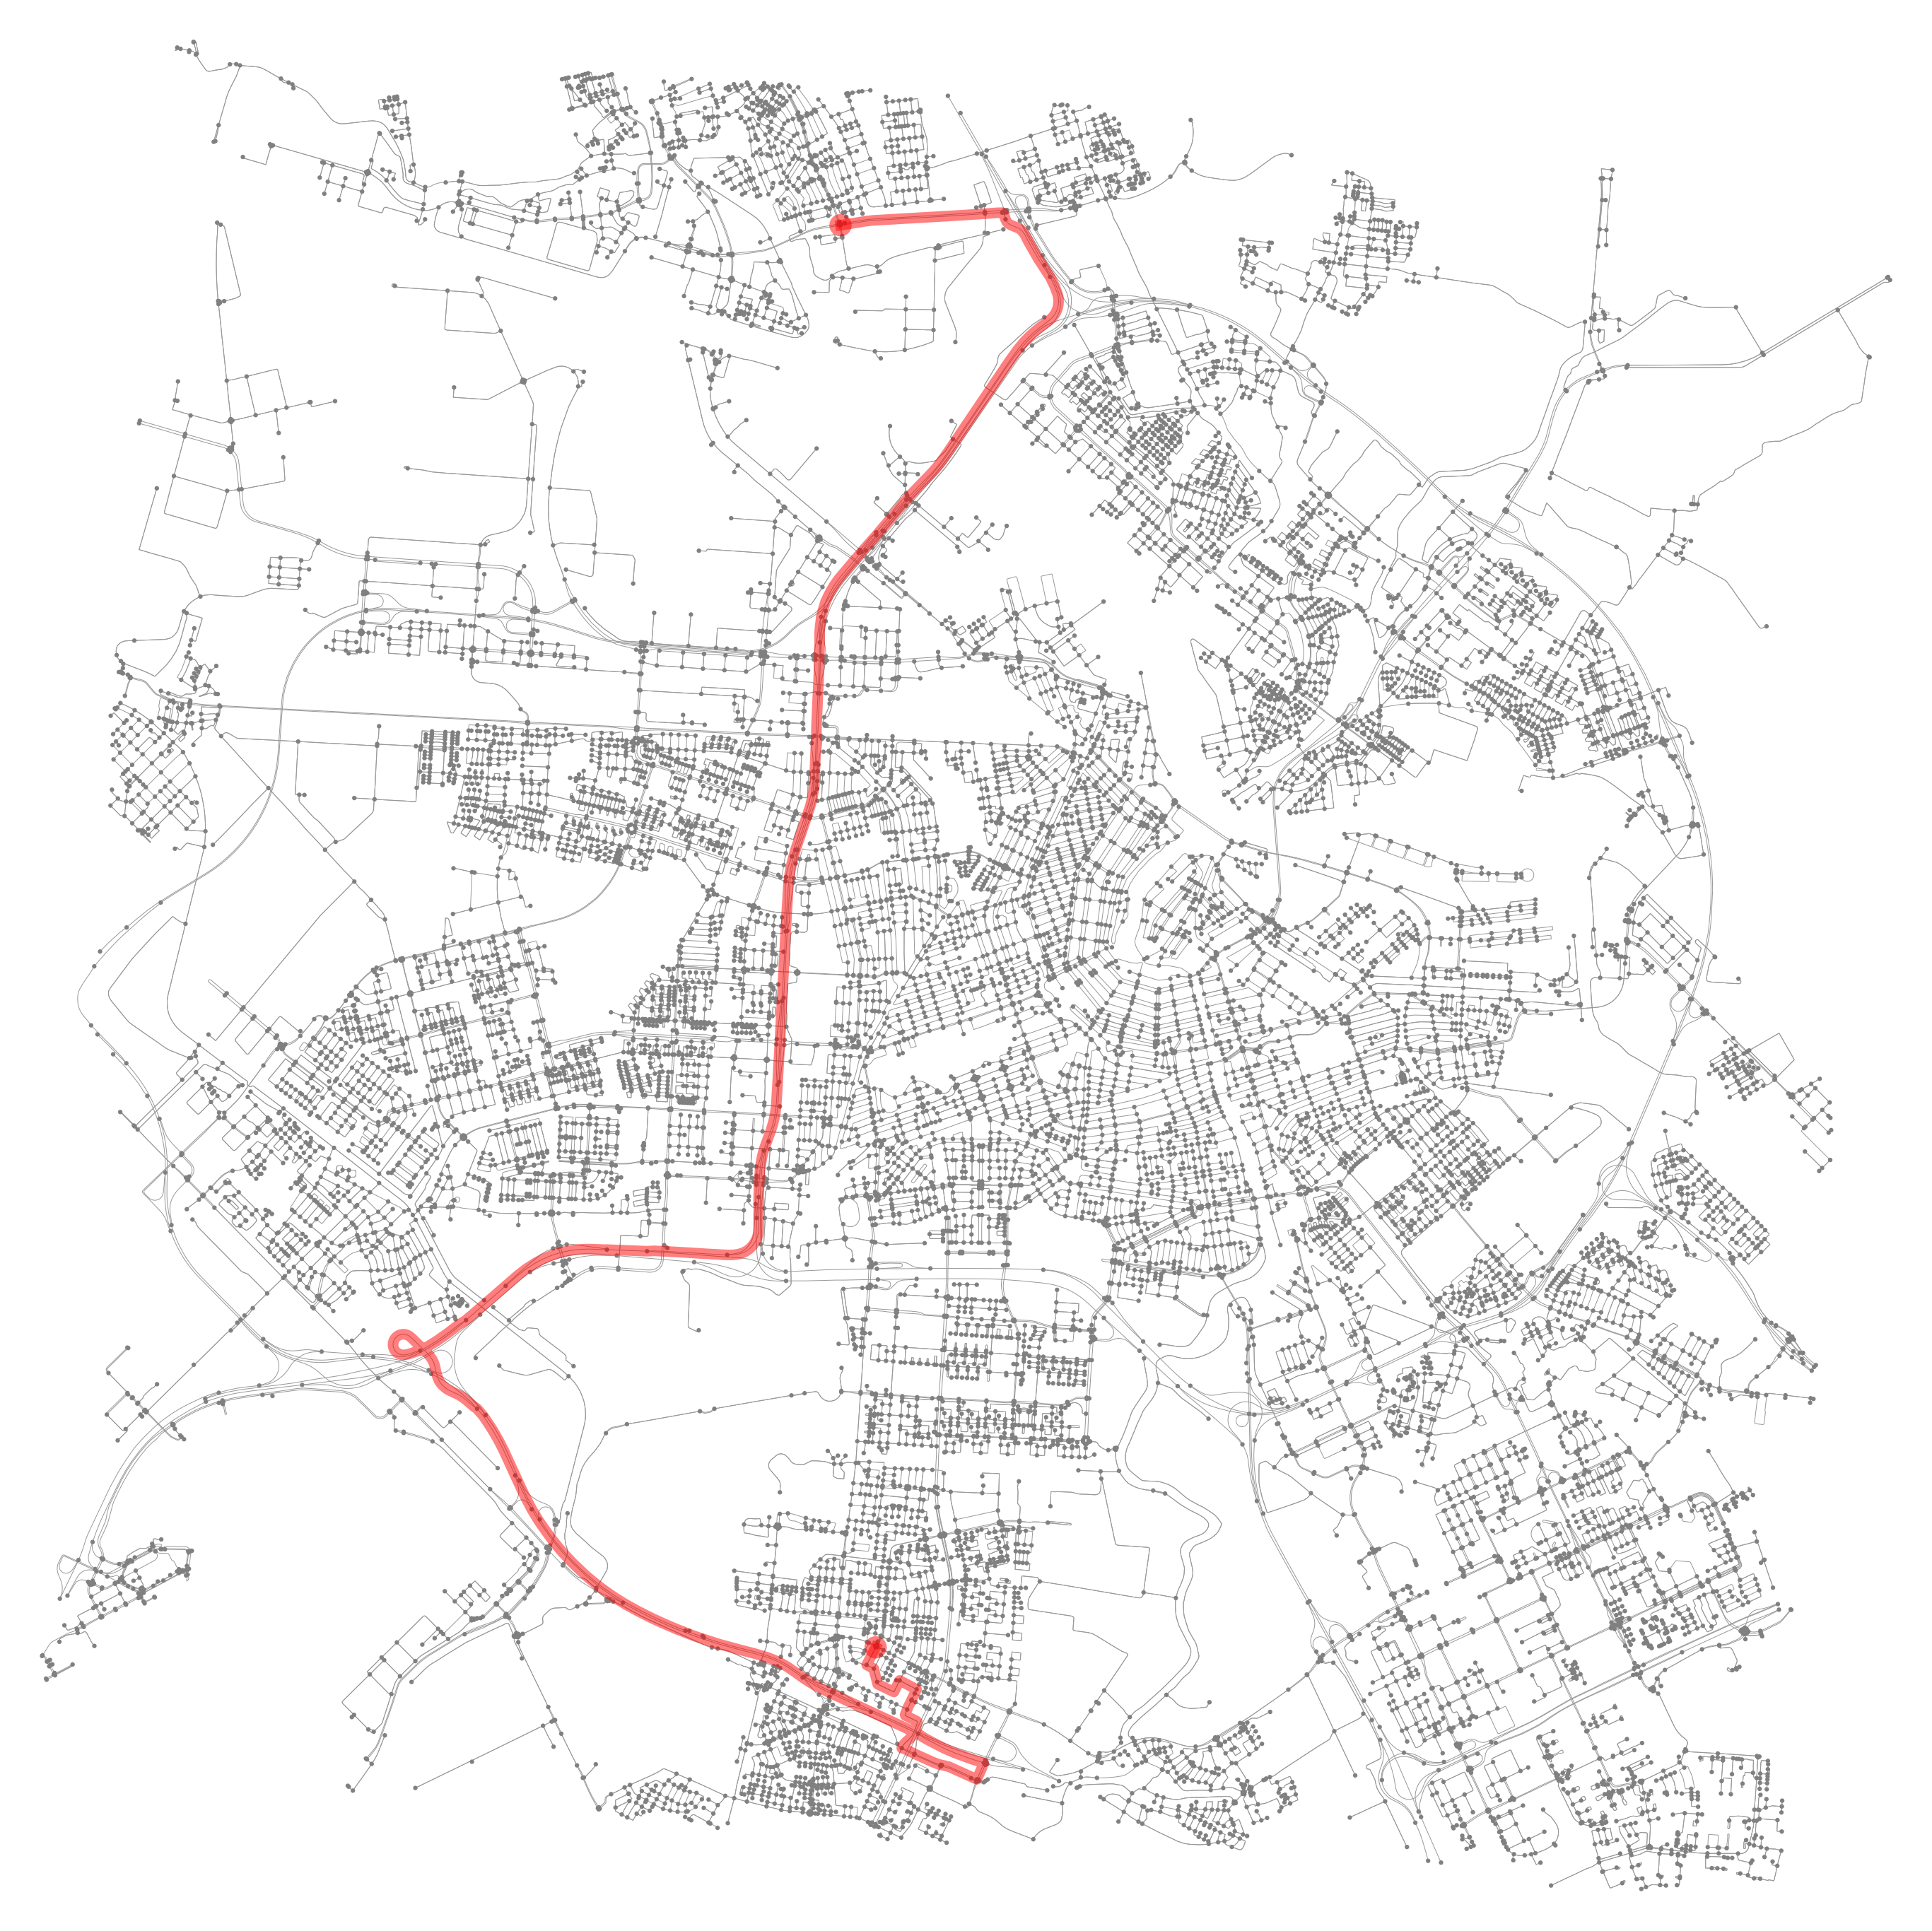

(<Figure size 3600x3600 with 1 Axes>, <AxesSubplot:>)

In [99]:
p=get_nodes_of_way(final_routes[0][:-1],G2, 'forward')
#print(p)
ox.plot_graph_route(projected, p,node_color='grey',figsize=(50,50),node_size=40,bgcolor='white',edge_linewidth=1,route_linewidth=15,orig_dest_size=1000)
#print(graph_G[1][(graph_G[1].U==46332982)|(graph_G[1].U==46332925)])

In [65]:
address = 'Amstelveenseweg 186'
Route=readFile(address)
last_step = 'Coentunnelweg'
path = []#get_intersection_of_streets(last_step,last_step)
print(path, type(path))
for step in Route.steps:
    try:
        street = step.data['street']
        print(street)
        r = get_intersection_of_streets(last_step,street)
        print(r)
        last_step = street
        path.extend(r)
        #assert x
    except KeyError as AssertionError:
        pass
end = find_shortest_path(last_step,Route.destination)
path.extend(end)
print(path)
#path = sum(path, [])
#path = list(dict.fromkeys(path))

[] <class 'list'>
a10


NameError: name 'get_intersection_of_streets' is not defined

In [173]:
!jupyter nbconvert --to script *.ipynb

[NbConvertApp] Converting notebook NLP.ipynb to script
[NbConvertApp] Writing 9312 bytes to NLP.py
[NbConvertApp] Converting notebook map.ipynb to script
[NbConvertApp] Writing 30080 bytes to map.py


In [ ]:
#n1 = 46494259
#n2 = 3657588020
#r=  nx.shortest_path(G, n1, n2)
#ox.plot_graph_route(G, r)
#ox.save_graph_shapefile(G, filename=os.path.join('~/test_graph'))

In [93]:
rout_rembrandt= final_routes[0]

In [94]:
def write_out(address,data):
    with open(f'../../Data/Routes/Generated/{address}.pickle', 'wb') as pickleFile:
        pickle.dump(data, pickleFile)

In [149]:
def read_in_route(file):
    fileObj = open(file, "r") #opens the file in read mode
    words = eval(fileObj.read())
    coords=[]
    for node in words:
        coords.append([float(format(node[1], '.4f')),float(format(node[0], '.4f'))])
    return  coords

In [150]:
def generate_coords_from_route(route):
    p=get_nodes_of_way(route,G, 'forward')
    graph = ox.graph_to_gdfs(G)
    coords=[]
    for node in p:
        coords.append([float(format(graph[0].loc[node].y, '.4f')),float(format(graph[0].loc[node].x, '.4f')) ])
    return  coords

In [151]:
RembrandArray=read_in_route('/Users/balazs/Desktop/Thesis/Data/AH/Rembrandthof 49_ROUTE.txt')

/var/folders/dt/dm4sx9g923z7d3mbxdf5yv2m0000gp/T/ipykernel_27798/2968998935.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/balazs/Desktop/Thesis/Data/AH/Rembrandthof 49_ROUTE.txt' mode='r' encoding='UTF-8'>
  RembrandArray=read_in_route('/Users/balazs/Desktop/Thesis/Data/AH/Rembrandthof 49_ROUTE.txt')


In [110]:
write_out('Rembrandthof 49',final_routes[:-1])

In [170]:
def compare_arrays(a1,a2, path):
    length=[len(a1),len(a2)]
    centroids = [a1.sum(axis=0)/len(a1), a2.sum(axis=0)/len(a2)]
    #diff=centroids[0]-
    centroidDiff = geopy.distance.geodesic(centroids[0], centroids[1]).m
    same = 0
    for first in a1:
        node1 = ox.distance.nearest_nodes(G, first[1], first[0])
        for second in path:
            if node1 == second:
                same+=1
                break
    print(length, centroids,centroidDiff, same)

In [167]:
p=generate_coords_from_route(final_routes[0][:-1])
path = get_nodes_of_way(final_routes[0][:-1],G, 'forward')

In [171]:
comp[401, 454] [array([52.35164838,  4.83899676]), array([52.35416145,  4.83823833])] 284.374826216069 351are_arrays(np.array(RembrandArray),np.array(p), path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [172]:
diffEnd = geopy.distance.geodesic(RembrandArray[-1], p[-1]).m